# Introduction to Integer Programming

```{admonition} Learning outcomes
After reading this note, you will be able to:
- Model a discrete optimization problem using the language of integer linear programming
- Describe the branch-and-bound algorithm
```


## Problem statement
*Integer Linear Programming* (ILP) is not new to you. In fact, the bin packing problem from last week was modeled using the language of ILP as:
```{math}
\min_{\boldsymbol{x}, \boldsymbol{y}} \quad & \sum_{i=1}^{n}{y_i}\\
\text{subject to} \quad 
& \sum_{j=1}^{n}{w_j x_{ij}} \leq c y_i, \quad &\forall i\in[n],\\
& \sum_{i=1}^{n}{ x_{ij}} = 1, \quad&\forall j\in[n],\\
& y_i\in\{0,1\}, \quad &\forall i\in[n],\\
& x_{ij}\in\{0,1\}, \quad &\forall i\in[n],j\in[n].
```
An ILP consists of integer decision variables, an objective function that is linear in those variables, and constraints that are linear in those variables as well. If any of the decision variables is required to be continuous, the optimization problem becomes a *Mixed*-Integer Linear Program (MILP). The word "program" or "programming" here do not refer to writing code but rather to optimization; think of it as mixed-integer linear optimization if you so prefer.

A MILP with $n$ integer variables $\boldsymbol{x}$, $p$ continuous variables $\boldsymbol{y}$, and $m$ linear inequality constraints (we can also use equality constraints), writes:
```{math}
\min_{\boldsymbol{x}, \boldsymbol{y}} \quad & \boldsymbol{c}^\intercal\boldsymbol{x} +\boldsymbol{h}^\intercal\boldsymbol{y} =\sum_{i=1}^{n}{c_i x_i}+\sum_{j=1}^{p}{h_j y_j}\\
\text{subject to} \quad 
& \sum_{i=1}^{n}{a_{k,i} x_{i}} + \sum_{j=1}^{p}{g_{k,j} y_{j}}  \leq b_k, \quad &\forall k\in[m],\\
& x_{i}\in\mathbb{N}, \quad &\forall i\in[n],\\
& y_{j}\in\mathbb{R}_{\geq 0}, \quad &\forall j\in[p].
```
Note that $\mathbb{N}=\{0,1,2,\dots\}$ is the set of natural integers. If we organize the constraint coefficients $a_{k,i}$ into a matrix $\boldsymbol{A}$ with $m$ rows (one per constraint) and $n$ columns (one per variable), then the $m$ values for $\sum_{i=1}^{n}{a_{k,i} x_{i}}$ can be written neatly as $\boldsymbol{A}\boldsymbol{x}$, where $\boldsymbol{x}$ is a column vector of dimension $n$. The same can be done with the continuous variables. Organizing the right-hand side constraint coefficents $b_k$ into a column vector $\boldsymbol{b}$, the linear constraints can be re-expressed compactly as:
```{math}
\boldsymbol{A}\boldsymbol{x} + \boldsymbol{G}\boldsymbol{y} \leq \boldsymbol{b}
```
These linear inequality can constrains typically include upper bounds on the variables, i.e., constraints of the form $x_i\leq u_i$. 

## Lower and upper bounds to a MILP's optimal value
### The LP Relaxation lower bounds
We have also already looked at the concept of a relaxation. The Linear Programming (LP) relaxation of a MILP simply removes the requirement of integrality for the relevant decision variables. 
```{math}
\min_{\boldsymbol{x}, \boldsymbol{y}} \quad & \boldsymbol{c}^\intercal\boldsymbol{x} +\boldsymbol{h}^\intercal\boldsymbol{y}\\
\text{subject to} \quad 
&\boldsymbol{A}\boldsymbol{x} + \boldsymbol{G}\boldsymbol{y} \leq \boldsymbol{b},\\
& x_{i}\in\mathbb{R}_{\geq 0}, \quad &\forall i\in[n],\\
& y_{j}\in\mathbb{R}_{\geq 0}, \quad &\forall j\in[p].
```
Let $\Omega$ be the non-empty set of feasible solutions of a MILP and $\Omega'$ that of its relaxation's. Let $z^{\star}(\Omega)$ be the *optimal value* of the MILP and $z^{\star}(\Omega')$ that of the LP relaxation. The following inequality holds true:
```{math}
z^{\star}(\Omega')\leq z^{\star}(\Omega).
```
In words, the relaxation's optimal value is an *optimistic* lower bound on the optimal value of the MILP. 

### A feasible solution upper bounds
Now consider an integer-feasible solution $(\boldsymbol{\hat{x}},\boldsymbol{\hat{y}})\in\Omega$ to the MILP. The best objective function value it can it achieve is the optimal value of the MILP, $z^{\star}(\Omega)$, so it upper bounds it:
```{math}
z^{\star}(\Omega')\leq z^{\star}(\Omega)\leq \boldsymbol{c}^\intercal\boldsymbol{\hat{x}} +\boldsymbol{h}^\intercal\boldsymbol{\hat{y}}.
```

In [1]:
from sympy import * #Symbol, symbols, sin, cos, Polygon, solve, lambdify, Rational, pi, N
from sympy.plotting import plot
from spb import *
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['figure.dpi'] = 200

sns.set_theme()
sns.set_context("notebook", font_scale=1.1, rc={"lines.linewidth": 3.5})
sns.set_style("white")
sns.set_style("ticks")
plt.rcParams.update({
    "text.usetex": True,
    # "font.family": "courier",
    'text.latex.preamble': r'\usepackage{amsfonts}'
})

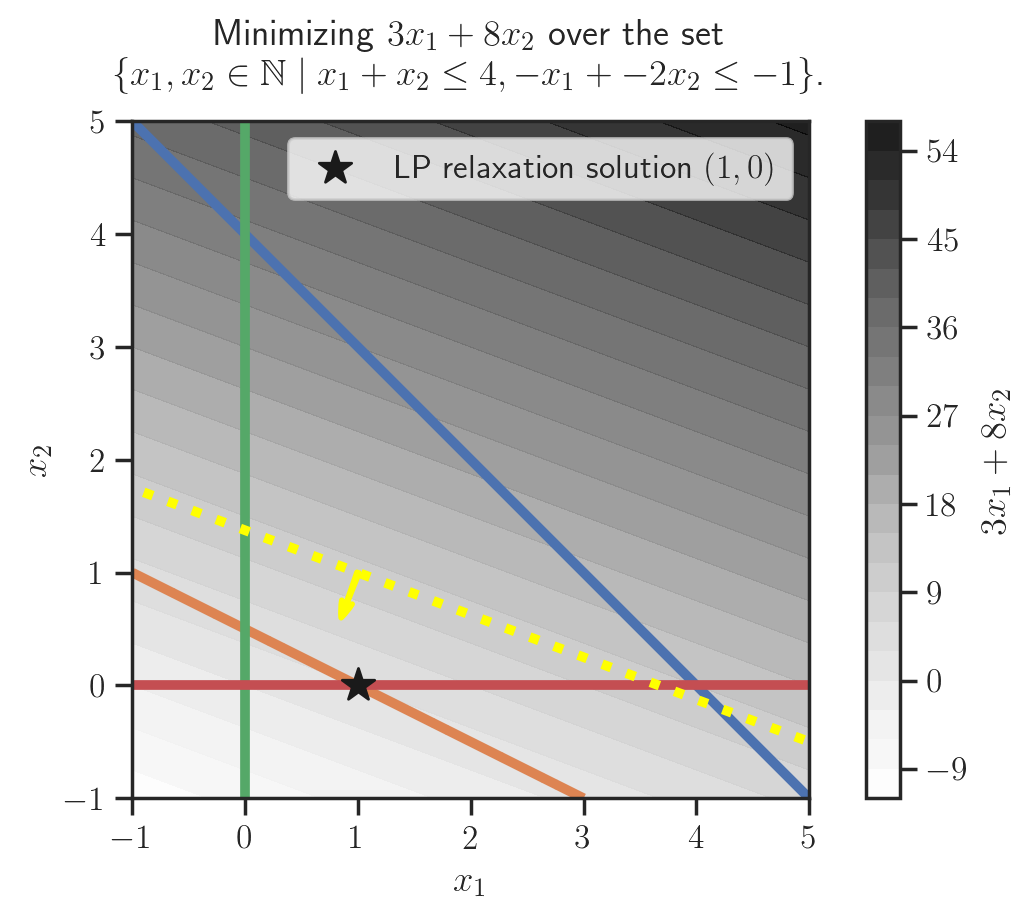

In [10]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 0),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 3*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-3.0/8)*x1 + 11.0/8, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "Minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1 + -2x_2 \leq -1\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 1), (-.15,-.4), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# plt.scatter(maximizer[1][x1], maximizer[1][x2], marker='*', s=150, color='yellow', zorder=100, label='maximizer $(%d,%d)$' % (maximizer[1][x1], maximizer[1][x2]))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='k', zorder=100, label='LP relaxation solution $(%d,%d)$' % (minimizer[1][x1], minimizer[1][x2]))


p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()

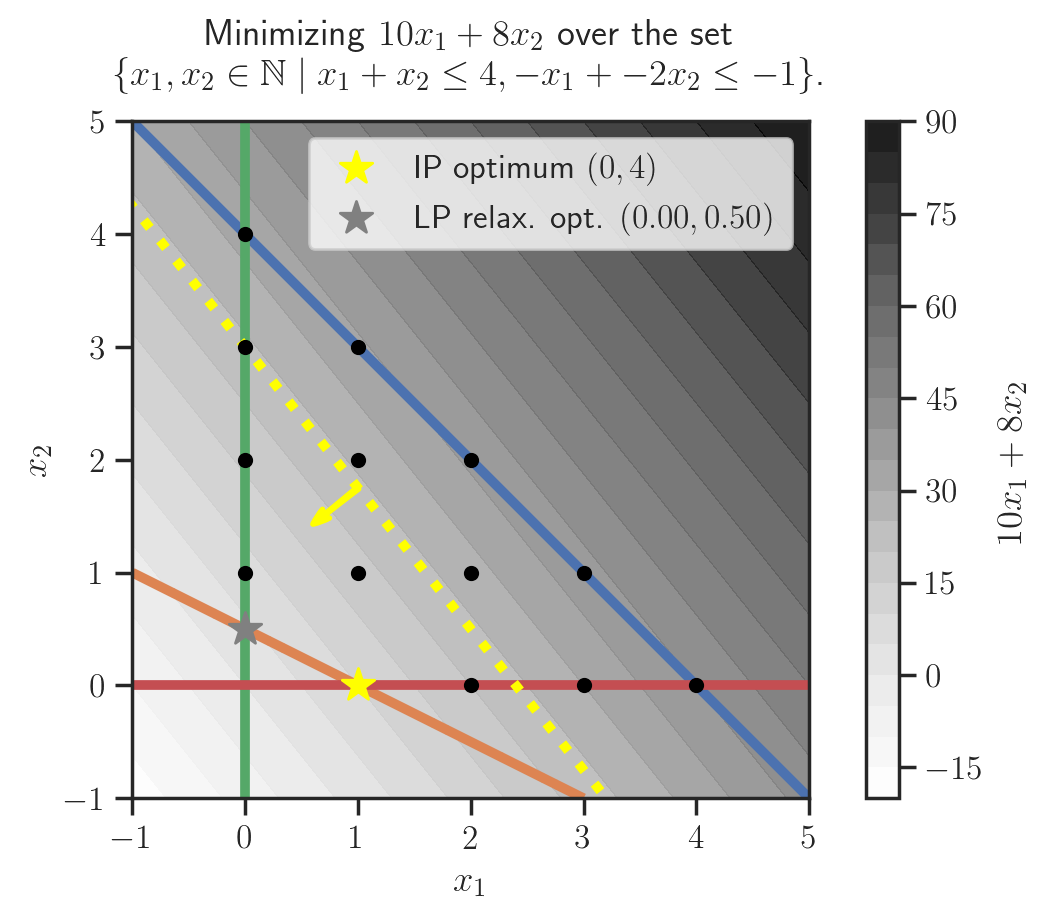

In [26]:
fig, ax = plt.subplots()
# ax.set_axis_off()

x1, x2 = symbols('x1 x2')
p1 = plot_implicit(
    Eq(x1 + x2 - 4, 0),
    Eq(-x1 + -2*x2 + 1, 0),
    Eq(x1, 0),
    Eq(x2, 0),
    (x1, -1, 5), (x2, -1, 5),
    {"linestyles": "-"}, aspect="equal",
    show=False, grid=False, show_in_legend=False, fig=fig, ax=ax)

objective_function = 10*x1+8*x2
objective_contour = plot_contour(objective_function,  (x1, -1, 5), (x2, -1, 5), 
                                 {"levels": 25, "cmap": "Greys", "alpha":0.9, "linestyles": "-", "linewidths": 1.5}, 
                                 is_filled=True, show=False, legend=False, fig=fig, ax=ax)
objective_line = plot((-10.0/8)*x1 + 3, rendering_kw={'color':'yellow','linestyle':':'}, show_in_legend=False, show=False, legend=False, fig=fig, ax=ax)

ax.set_title(
    "Minimizing $%s$ over the set\n $\{x_1, x_2\in\mathbb{N}\;|\;x_1 + x_2 \leq 4, -x_1 + -2x_2 \leq -1\}$."
    % latex(objective_function),y=1.03)

obj_vec = graphics(arrow_2d((1, 14.0/8), (-.4,-.32), rendering_kw={'color':'yellow','linewidth':2}, show_in_legend=False), show=False, fig=fig, ax=ax)

from sympy.solvers.simplex import lpmax
minimizer = (lpmax(-objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
# maximizer = (lpmax(objective_function, [x1 + x2 - 4 <= 0, -x1 + -2*x2 + 1 <= 0, x1 >= 0, x2 >= 0]))
plt.scatter(1, 0, marker='*', s=150, color='yellow', zorder=100, label='IP optimum $(%d,%d)$' % (maximizer[1][x1], maximizer[1][x2]))
plt.scatter(minimizer[1][x1], minimizer[1][x2], marker='*', s=150, color='grey', zorder=100, label='LP relax. opt. $(%.2f,%.2f)$' % (minimizer[1][x1], minimizer[1][x2]))

integer_points = [(0,1),(0,2),(0,3),(0,4),(1,0),(1,1),(1,2),(1,3),(2,0),(2,1),(2,2),(3,0),(3,1),(4,0)]
for point in integer_points:
    plt.scatter(point[0], point[1], marker='o', s=20, color='black', zorder=90)

p1.append(objective_contour[0])
p1.append(objective_line[0])
p1.append(obj_vec[0])
p1.show()